In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
def filt(image, kernel):
    image_dims = image.shape
    kernel_dims = kernel.shape
    out = np.zeros((image.shape[0] - kernel.shape[0], image.shape[1] - kernel.shape[1]))
    for i in range(out.shape[0]):
        for j in range(out.shape[1]):
            for k in range(kernel.shape[0]):
                for l in range(kernel.shape[1]):
                    out[i][j] += (image[i+k][j+l]*kernel[k][l])
    return out

In [8]:
#Problem 1 - create a my_imfilter function
def my_imfilter(image, kernel):
    kernel_dims = kernel.shape
    image_dims = image.shape
    dims = len(image_dims)
    if kernel_dims[0] % 2 == 0 or kernel_dims[1] % 2 == 0:
        raise ValueError("Both Kernel Dimensions Must Be Odd")
    if dims < 2 or dims > 3:
        raise ValueError("Only Grayscale and RGB Images are Supported")
    
    if dims == 2:
        print("Image is grayscale")
        image = np.pad(image, ((kernel.shape[0]//2, kernel.shape[0]//2+1), 
                               (kernel.shape[1]//2, kernel.shape[1]//2+1)))
        out = filt(image, kernel)
    if dims == 3:
        print("Image is RGB")
        b, g, r = cv2.split(image)
        for i, j in (b, g, r):
            i = np.pad(i, ((kernel.shape[0]//2, kernel.shape[0]//2+1), 
                                   (kernel.shape[1]//2, kernel.shape[1]//2+1)))
            i = filt(i, kernel)
        
        out = cv2.merge((b, g, r))
    return out

Image is RGB


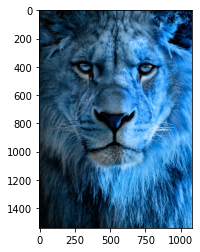

In [9]:
#Problem 2
def main():
    image = cv2.imread("Image3.jpg",)
    kernel = (1/9)*np.array([[1, 1, 1], [1, 1, 1], [1, 1,1 ]])
    out = my_imfilter(image, kernel)
    plt.imshow(out)
main()